In [2]:
# Machine learning pipeline for Doench Data, supplementary table 7
import pandas as pd

supp_7_path = "/Users/daveistanto/Dropbox/UIUCGraduateSchool/Researches/CROPSR_head_dir/data_files/supp_table_7.csv"
supp_7_df = pd.read_csv(supp_7_path)

In [3]:
# Sort based on Gene % Rank, take top 20
# import warnings
# warnings.filterwarnings('ignore')

# supp_7_df.sort_values(by="Gene % Rank", ascending=False, inplace=True)
# supp_7_df["Top 20%"] = False
# supp_7_df["Top 20%"][0:int(len(supp_7_df)*0.5)] = True


In [4]:
# # Sort based on Gene % Rank but group by Gene
import warnings
warnings.filterwarnings('ignore')
unique_gene_list = list(set(supp_7_df["Gene"]))

supp_7_df["Top 20%"] = False

for gene in unique_gene_list:
    supp_7_df_temp = supp_7_df[supp_7_df["Gene"] == gene]
    supp_7_df_temp["Top 20%"][0:int(len(supp_7_df_temp)*0.2)] = True
    supp_7_df[supp_7_df["Gene"] == gene] = supp_7_df_temp
    

In [5]:
# Extract features

import Feature_Extraction as fe

feat_vec = supp_7_df["Expanded Sequence"].apply(fe.ext_sgRNA_feat)

print(supp_7_df.columns)

Index(['Sequence', 'Expanded Sequence', 'Position', 'Type', 'Gene',
       'Transcript', 'Strand', 'Gene % Rank', 'sgRNA Score', 'Top 20%'],
      dtype='object')


In [6]:
print(len(feat_vec[0]))

590


In [7]:
# Split dataset to 80% Training 20% Test
from sklearn.model_selection import train_test_split 
import numpy as np

vec_train, vec_test, label_train, label_test = train_test_split(feat_vec.values, supp_7_df["Top 20%"].values, test_size=0.2, random_state=0)
# Convert nested np.array to 2d np.array
vec_train = np.array(list(vec_train))
vec_test = np.array(list(vec_test))

In [8]:
# Eliminate most features: SVM with L-1 regularization constant

from sklearn.svm import LinearSVC

SVM_clf = LinearSVC(penalty='l1', loss='squared_hinge', dual=False)
SVM_clf.fit(vec_train, label_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [9]:
# SVM Accuracies

from sklearn.metrics import accuracy_score

pred_train_SVM = SVM_clf.predict(vec_train)
pred_test_SVM = SVM_clf.predict(vec_test)

print("SVM Training accuracy:", accuracy_score(pred_train_SVM, label_train))
print("SVM Test accuracy:", accuracy_score(pred_test_SVM, label_test))

SVM Training accuracy: 0.8987771739130435
SVM Test accuracy: 0.7262872628726287


In [10]:
# Diagnostics

print("SVM Positive score:", SVM_clf.intercept_ + np.dot(SVM_clf.coef_, (vec_train[label_train == True][0])))
print("SVM Negative score:", SVM_clf.intercept_ + np.dot(SVM_clf.coef_, (vec_train[label_train != True][0])))

print(len(set(SVM_clf.coef_[0])))

SVM Positive score: [0.74583362]
SVM Negative score: [-0.37164422]
301


In [11]:
# Function for filtering, make vectorized version

def filter_vec(input_vec, filter_bool):
    return input_vec[filter_bool[0]]

In [12]:
# Filter for non-0 weights, and only use corresponding features

non_0_filter = (SVM_clf.coef_ != 0)
non_0_weights = SVM_clf.coef_[non_0_filter]
filtered_vec_train = np.apply_along_axis(filter_vec, 1, vec_train, non_0_filter)
filtered_vec_test = np.apply_along_axis(filter_vec, 1, vec_test, non_0_filter)

In [13]:
# Logistic Regression using filtered weights

from sklearn.linear_model import LogisticRegression
LR_clf = LogisticRegression()
LR_clf.fit(filtered_vec_train, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
# Logistic Regression Accuracies

pred_train_LR = LR_clf.predict(filtered_vec_train)
pred_test_LR = LR_clf.predict(filtered_vec_test)

print("LR Training accuracy:", accuracy_score(pred_train_LR, label_train))
print("LR Test accuracy:", accuracy_score(pred_test_LR, label_test))

LR Training accuracy: 0.8953804347826086
LR Test accuracy: 0.7100271002710027


In [15]:
#DISTRIBUTIONS
train_unique, train_counts = np.unique(pred_train_LR, return_counts=True)
test_unique, test_counts = np.unique(pred_test_LR, return_counts=True)
print("training set counts", dict(zip(train_unique, train_counts)))
print("test set counts", dict(zip(test_unique, test_counts)))

print("training set frequency", dict(zip(train_unique, train_counts/(train_counts[0]+ train_counts[1]))))
print("test set frequency", dict(zip(test_unique, test_counts/(test_counts[0]+ test_counts[1]))))


training set counts {False: 1281, True: 191}
test set counts {False: 292, True: 77}
training set frequency {False: 0.8702445652173914, True: 0.1297554347826087}
test set frequency {False: 0.7913279132791328, True: 0.2086720867208672}


In [16]:
# Function to get scores of each input vector
import math

def get_sgRNA_scores(input_vector, incpt, weights):
    raw_score = incpt + np.dot(input_vector, weights)
    prob_top_20 = 1 / (1 + (math.e)**(-1 * raw_score))
    
    return prob_top_20


In [17]:
# Get scores of each feature

feat_vec = np.array(list(feat_vec))
filtered_feat_vec = np.apply_along_axis(filter_vec, 1, feat_vec, non_0_filter)
supp_7_df["exp_score"] = np.apply_along_axis(get_sgRNA_scores, 1, filtered_feat_vec, LR_clf.intercept_, LR_clf.coef_[0])

In [18]:
# Sort df by exp score

Doench_rank = supp_7_df.sort_values(by="Gene % Rank", ascending=False, inplace=False)
CROPSR_rank = supp_7_df.sort_values(by="exp_score", ascending=False, inplace=False)

#Doench_rank.to_csv("/Users/daveistanto/Dropbox/UIUCGraduateSchool/Researches/CROPSR/data_files/doench_ranked.csv", index=False)
#CROPSR_rank.to_csv("/Users/daveistanto/Dropbox/UIUCGraduateSchool/Researches/CROPSR/data_files/CROPSR_ranked.csv", index=False)

Correlation coefficient:  0.4724535626309528
Correlation coefficient:  0.5379907580176214


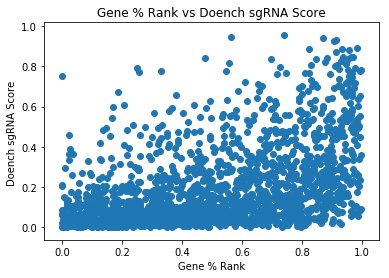

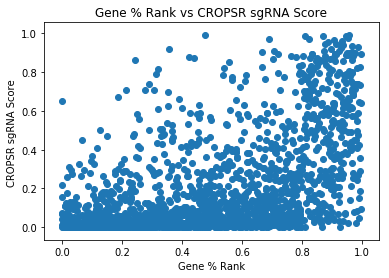

In [19]:
# Scatter plot sgRNA vs Doench Gene rank

import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

plt.figure(1)
plt.scatter(Doench_rank["Gene % Rank"].values, Doench_rank["sgRNA Score"].values)
plt.ylabel("Doench sgRNA Score ")
plt.xlabel("Gene % Rank")
plt.title("Gene % Rank vs Doench sgRNA Score")

print("Correlation coefficient: ", pearsonr(Doench_rank["Gene % Rank"].values, Doench_rank["sgRNA Score"].values)[0])

plt.figure(2)
plt.scatter(CROPSR_rank["Gene % Rank"].values, CROPSR_rank["exp_score"].values)
plt.ylabel("CROPSR sgRNA Score ")
plt.xlabel("Gene % Rank")
plt.title("Gene % Rank vs CROPSR sgRNA Score")

print("Correlation coefficient: ", pearsonr(CROPSR_rank["Gene % Rank"].values, CROPSR_rank["exp_score"].values)[0])

In [19]:
# Logistic Regression only

from sklearn.linear_model import LogisticRegression
LR_only_clf = LogisticRegression()
LR_only_clf.fit(vec_train, label_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
# Logistic Regression only Accuracies

from sklearn.metrics import accuracy_score

pred_train_only_LR = LR_only_clf.predict(vec_train)
pred_test_only_LR = LR_only_clf.predict(vec_test)

print("LR Only Training accuracy:", accuracy_score(pred_train_only_LR, label_train))
print("LR Only Test accuracy:", accuracy_score(pred_test_only_LR, label_test))

LR Only Training accuracy: 0.8980978260869565
LR Only Test accuracy: 0.7154471544715447


In [21]:
# Linear neural network Classifier, ranked

import torch
from torch import nn

p_threshold = 0.5
class nnClassifier(nn.Module):
    def __init__(self):
        super(nnClassifier, self).__init__()
        
        self.lin_1 = nn.Linear(590, 300)
        self.lin_2 = nn.Linear(300, 100)
        self.lin_3 = nn.Linear(100, 10)
        self.lin_4 = nn.Linear(10, 1)
        
        self.seq = nn.Sequential(
            self.lin_1,
            nn.ReLU(),
            self.lin_2,
            nn.ReLU(),
            self.lin_3,
            nn.ReLU(),
            self.lin_4,
            nn.Sigmoid()
        )

    def forward(self, x):
        prob = self.seq(x.type(torch.FloatTensor))
        label_tensor = prob > p_threshold
     
        return prob, label_tensor.type(torch.FloatTensor)
        


In [22]:
from torch.utils.data import Dataset, DataLoader
# Data loaders, training and test loader

class mouse_dataset(Dataset):
    
    # Initialize data
    def __init__(self, input_x, input_y):
        self.len = len(input_x)
        self.x_data = torch.from_numpy(input_x)
        self.y_data = torch.from_numpy(input_y)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
mouse_train_dataset = mouse_dataset(vec_train, label_train.astype(int))
mouse_test_dataset = mouse_dataset(vec_test, label_test.astype(int))

# mouse_train_filtered_dataset = mouse_dataset()


In [52]:
# Code for training test nn

import torch
import torch.nn.functional as F

def train_test_nn(model, train_loader, test_loader, loss_func, opt, epochs=10, writer=None):
    
#     Divide training data to batches:
    

    for epoch_index in range(epochs):
        
        # Train nn 
        train_epoch_total_loss = 0
        train_epoch_total_acc = 0
        train_total_batches = 0
        
        for i, data in enumerate(train_loader, 0):
            
            # Load data and forward
            train_input, train_labels = data         
            train_prob_good, train_pred_labels = model(train_input)

            # Loss, back propagation
            train_batch_loss = loss_func(train_prob_good, train_labels)
            opt.zero_grad()
            train_batch_loss.backward()
            opt.step()
            
            # Metrics
            train_epoch_total_loss += train_batch_loss.item()
            train_epoch_total_acc += hybrid_get_accuracy(train_pred_labels, train_labels)
            train_total_batches += 1
                

        # Test nn
        test_epoch_total_loss = 0
        test_epoch_total_acc = 0
        test_total_batches = 0

        for i, data in enumerate(test_loader, 0):

            # Load data, forward
            test_input, test_labels = data
            test_prob_good, test_pred_labels = model(test_input)
            
            # Loss
            test_batch_loss = loss_func(test_prob_good, test_labels)
            
            # Metrics
            test_epoch_total_loss += test_batch_loss.item()
            test_epoch_total_acc += hybrid_get_accuracy(test_pred_labels, test_labels)
            test_total_batches += 1

            
        if epoch_index % 200 == 0 or epoch_index == epochs - 1:
            print("Now at epoch", epoch_index)
#         if epoch_index % 50 == 0 or epoch_index == epochs - 1:
#             print("Epoch", epoch_index, "Training Accuracy:", train_epoch_total_acc / train_total_batches)
#             print("Epoch", epoch_index, "Training Loss:", train_epoch_total_loss / train_total_batches)
#             print("Epoch", epoch_index, "Test Accuracy:", test_epoch_total_acc / test_total_batches)
#             print("Epoch", epoch_index, "Test Loss:", test_epoch_total_loss / test_total_batches)
#             # Get epoch average batch loss and accuracy
#         writer.add_scalar("Epoch Training Batch Loss Average:", train_epoch_total_loss / train_total_batches, epoch_index)
#         writer.add_scalar("Epoch Training Batch Accuracy Average:", train_epoch_total_acc / train_total_batches, epoch_index)
#         writer.add_scalar("Epoch Test Batch Loss Average:", test_epoch_total_loss / test_total_batches, epoch_index)
#         writer.add_scalar("Epoch Test Batch Accuracy Average:", test_epoch_total_acc / test_total_batches, epoch_index)     
         
    return (test_epoch_total_acc / test_total_batches)
            


    

In [50]:
# new get accuracy function

def hybrid_get_accuracy(pred_label, actual_label):
    pred_label = pred_label.view(pred_label.size()[0]).type(torch.LongTensor)

    eq_tensor = (actual_label == pred_label)
    
    acc = torch.sum(eq_tensor).item()/ eq_tensor.size()[0]
    
    return acc

In [25]:
# 2-Class classification Helper function
def class_get_accuracy(model_output_tensor, actual_value_tensor):
    # Get the node / torch with largest value, multiple tensors at once,
    # torch.max returns (max_value, index_of_max_value)
    max_val_indices = torch.max(model_output_tensor, dim = 1)[1]
    
    # Get the number of rights, item() is to extract scalar from 1D tensor with 1 Element
    right_count = torch.sum(torch.eq(max_val_indices, actual_value_tensor)).item()
    
    # Get accuracy by dividing by length of each tensor
    batch_size = max_val_indices.size()[0]
    acc = right_count / batch_size
    return acc


In [26]:
# Logistic regression loss helper
import torch
def get_logreg(pred, target):

    pred = pred.view(pred.size()[0])
    target = target.type(torch.FloatTensor)
    loss = torch.mul(target, torch.mul(-1, torch.log(pred))) + torch.mul(1 - target, torch.mul(-1, torch.log(1 - pred)))

    mean_loss = torch.mean(loss)
    
    return mean_loss

In [265]:
# Train model
from torch import optim
from tensorboardX import SummaryWriter

model = nnClassifier()
mouse_train_loader = DataLoader(dataset=mouse_train_dataset, batch_size = 32, shuffle = True, num_workers = 2)
mouse_test_loader = DataLoader(dataset=mouse_test_dataset, batch_size = 32, shuffle = True, num_workers = 2)
#loss_1 = nn.CrossEntropyLoss()
loss_1 = get_logreg
optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.0001)
writer = SummaryWriter()


train_test_nn(model, mouse_train_loader, mouse_test_loader, loss_1, optimizer, epochs=850, writer=writer)

Epoch 0 Training Accuracy: 0.6039402173913043
Epoch 0 Training Loss: 0.6814770452354265
Epoch 0 Test Accuracy: 0.5684742647058824
Epoch 0 Test Loss: 0.6834214727083842
Epoch 50 Training Accuracy: 0.6086956521739131
Epoch 50 Training Loss: 0.6663985731809036
Epoch 50 Test Accuracy: 0.5730698529411765
Epoch 50 Test Loss: 0.6831657638152441
Epoch 100 Training Accuracy: 0.6086956521739131
Epoch 100 Training Loss: 0.665088898461798
Epoch 100 Test Accuracy: 0.5776654411764706
Epoch 100 Test Loss: 0.6799903512001038
Epoch 150 Training Accuracy: 0.6086956521739131
Epoch 150 Training Loss: 0.6630852261315221
Epoch 150 Test Accuracy: 0.5868566176470588
Epoch 150 Test Loss: 0.6739490528901418
Epoch 200 Training Accuracy: 0.6086956521739131
Epoch 200 Training Loss: 0.6602168692194897
Epoch 200 Test Accuracy: 0.5776654411764706
Epoch 200 Test Loss: 0.6752938578526179
Epoch 250 Training Accuracy: 0.6086956521739131
Epoch 250 Training Loss: 0.6560253578683605
Epoch 250 Test Accuracy: 0.57996323529411

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
import numpy as np
from torch import optim
# Statistical Tests on Test Accuracy

N = 10
SVM_LR = np.array([])
LR_only = np.array([])
NN_only = np.array([])

for i in range(N):
    
    print("Currently in iteration:", i)
    # Shuffle test and training sets
    
    vec_train, vec_test, label_train, label_test = train_test_split(feat_vec, supp_7_df["Top 20%"], test_size=0.2, random_state=0)
    # Convert nested np.array to 2d np.array
    vec_train = np.array(list(vec_train))
    vec_test = np.array(list(vec_test))

    print("Now starting 1")
    # 1. SVM -> Logistic Regression
    SVM_clf.fit(vec_train, label_train)
    
    # Filter for non-0 weights, and only use corresponding features
    non_0_filter = (SVM_clf.coef_ != 0)
    non_0_weights = SVM_clf.coef_[non_0_filter]
    filtered_vec_train = np.apply_along_axis(filter_vec, 1, vec_train, non_0_filter)
    filtered_vec_test = np.apply_along_axis(filter_vec, 1, vec_test, non_0_filter)
    
    # Logistic Regression using filtered weights
    from sklearn.linear_model import LogisticRegression
    LR_clf = LogisticRegression()
    LR_clf.fit(filtered_vec_train, label_train)
    pred_test_LR = LR_clf.predict(filtered_vec_test)
    SVM_LR_acc = accuracy_score(pred_test_LR, label_test)
    print("SVM LR accuracy:", SVM_LR_acc)
    
    print("Now starting 2")
    # 2. LR Only
    LR_only_clf = LogisticRegression()
    LR_only_clf.fit(vec_train, label_train)
    pred_test_only_LR = LR_only_clf.predict(vec_test)
    LR_only_acc = accuracy_score(pred_test_only_LR, label_test)
    print("LR only accuracy:", LR_only_acc)
    
    print("Now starting 3")
    # 3. NN Only
    model = nnClassifier()
    mouse_train_loader = DataLoader(dataset=mouse_train_dataset, batch_size = 32, shuffle = True, num_workers = 2)
    mouse_test_loader = DataLoader(dataset=mouse_test_dataset, batch_size = 32, shuffle = True, num_workers = 2)
    #loss_1 = nn.CrossEntropyLoss()
    loss_1 = get_logreg
    optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.0001)
    NN_acc = train_test_nn(model, mouse_train_loader, mouse_test_loader, loss_1, optimizer, epochs=850)
    print("NN only accuracy:", NN_acc)
    
    # Append each accuracy to the np.array
    SVM_LR = np.append(SVM_LR, SVM_LR_acc)
    LR_only = np.append(LR_only, LR_only_acc)
    NN_only = np.append(NN_only, NN_acc)
    
    

Currently in iteration: 0
Now starting 1
SVM LR accuracy: 0.7127371273712737
Now starting 2
LR only accuracy: 0.7154471544715447
Now starting 3
Now at epoch 0
Now at epoch 200
Now at epoch 400
Now at epoch 600
Now at epoch 800
Now at epoch 849
NN only accuracy: 0.7486213235294118
Currently in iteration: 1
Now starting 1
SVM LR accuracy: 0.7100271002710027
Now starting 2
LR only accuracy: 0.7154471544715447
Now starting 3
Now at epoch 0
Now at epoch 200
Now at epoch 400
Now at epoch 600
Now at epoch 800
Now at epoch 849
NN only accuracy: 0.7743566176470589
Currently in iteration: 2
Now starting 1
SVM LR accuracy: 0.7127371273712737
Now starting 2
LR only accuracy: 0.7154471544715447
Now starting 3
Now at epoch 0
Now at epoch 200
Now at epoch 400
Now at epoch 600
Now at epoch 800
Now at epoch 849
NN only accuracy: 0.7648590686274509
Currently in iteration: 3
Now starting 1
SVM LR accuracy: 0.7181571815718157
Now starting 2
LR only accuracy: 0.7154471544715447
Now starting 3
Now at epoch 

In [56]:
print(SVM_LR)
print(LR_only)
print(NN_only)

[0.71273713 0.7100271  0.71273713 0.71815718 0.71544715 0.71815718
 0.72086721 0.70731707 0.71815718 0.70731707]
[0.71544715 0.71544715 0.71544715 0.71544715 0.71544715 0.71544715
 0.71544715 0.71544715 0.71544715 0.71544715]
[0.74862132 0.77435662 0.76485907 0.77144608 0.76715686 0.77895221
 0.77634804 0.77175245 0.77435662 0.76746324]
